# CDI example loading data from a CXI file

In [1]:
%matplotlib notebook
import numpy as np
import h5py
from numpy.fft import fftshift
from scipy.ndimage.measurements import center_of_mass
import matplotlib.pyplot as plt

# This imports all necessary operators. GPU will be auto-selected
from pynx.cdi import *
from pynx.utils.math import smaller_primes

## Filename
Change to your CXI file

In [2]:
filename = "/Users/vincent/data/201702-BraggCDI-Pt/alignment_S2280.cxi"

## Extract data

In [3]:
cxi = h5py.File(filename, 'r')
if '/entry_1/instrument_1/source_1/energy' in cxi:
    nrj = cxi['/entry_1/instrument_1/source_1/energy'][()] / 1.60218e-16
    wavelength = 12.384 / nrj * 1e-10
    print("  CXI input: Energy = %8.2fkeV" % nrj)
else:
    wavelength = None
if '/entry_1/instrument_1/detector_1/distance' in cxi:
    detector_distance = cxi['/entry_1/instrument_1/detector_1/distance'][()]
    print("  CXI input: detector distance = %8.2fm" % detector_distance)
else:
    detector_distance = None
if '/entry_1/instrument_1/detector_1/x_pixel_size' in cxi:
    pixel_size_detector = cxi['/entry_1/instrument_1/detector_1/x_pixel_size'][()]
    print("  CXI input: detector pixel size = %8.2fum" % (pixel_size_detector * 1e6))
else:
    pixel_size_detector = None
print("  CXI input: loading iobs")
if 'entry_1/instrument_1/detector_1/data' in cxi:
    iobs = cxi['entry_1/instrument_1/detector_1/data'][()].astype(np.float32)
else:
    iobs = cxi['entry_1/data_1/data'].value.astype(np.float32)
# This is the detector mask
if 'entry_1/instrument_1/detector_1/mask' in cxi:
    mask = cxi['entry_1/instrument_1/detector_1/mask'][()].astype(np.int8)
    nb = mask.sum()
    print("  CXI input: loading mask, with %d pixels masked (%6.3f%%)" % (nb, nb * 100 / mask.size))
else:
    mask = None


  CXI input: Energy =     0.00keV
  CXI input: loading iobs
  CXI input: loading mask, with 1582092 pixels masked ( 2.312%)


## Centre & crop data
You can skip this if your data is already centred and if the arrays dimensions already have a prime factor decomposition with factors not larger than 7.

You can also change `max_size` to a larger value.

In [4]:
max_size = 256
if iobs.ndim == 3:
    nz0, ny0, nx0 = iobs.shape
    # Find center of mass
    z0, y0, x0 = center_of_mass(iobs)
    print("Center of mass at:", z0, y0, x0)
    iz0, iy0, ix0 = int(round(z0)), int(round(y0)), int(round(x0))
    # Max symmetrical box around center of mass
    nx = 2 * min(ix0, nx0 - ix0)
    ny = 2 * min(iy0, ny0 - iy0)
    nz = 2 * min(iz0, nz0 - iz0)
    if max_size is not None:
        nx = min(nx, max_size)
        ny = min(ny, max_size)
        nz = min(nz, max_size)
    # Crop data to fulfill FFT size requirements
    nz1, ny1, nx1 = smaller_primes((nz, ny, nx), maxprime=7, required_dividers=(2,))

    print("Centering & reshaping data: (%d, %d, %d) -> (%d, %d, %d)" % (nz0, ny0, nx0, nz1, ny1, nx1))
    iobs = iobs[iz0 - nz1 // 2:iz0 + nz1 // 2, iy0 - ny1 // 2:iy0 + ny1 // 2,
                ix0 - nx1 // 2:ix0 + nx1 // 2]
    if mask is not None:
        mask = mask[iz0 - nz1 // 2:iz0 + nz1 // 2, iy0 - ny1 // 2:iy0 + ny1 // 2,
                    ix0 - nx1 // 2:ix0 + nx1 // 2]
else:
    ny0, nx0 = iobs.shape
    # Find center of mass
    y0, x0 = center_of_mass(iobs)
    print("Center of mass at:", y0, x0)
    iy0, ix0 = int(round(y0)), int(round(x0))
    # Max symmetrical box around center of mass
    nx = 2 * min(ix0, nx0 - ix0)
    ny = 2 * min(iy0, ny0 - iy0)
    if max_size is not None:
        nx = min(nx, max_size)
        ny = min(ny, max_size)
        nz = min(nz, max_size)
    # Crop data to fulfill FFT size requirements
    ny1, nx1 = smaller_primes((ny, nx), maxprime=7, required_dividers=(2,))

    print("Centering & reshaping data: (%d, %d) -> (%d, %d)" % (ny0, nx0, ny1, nx1))
    iobs = iobs[iy0 - ny1 // 2:iy0 + ny1 // 2, ix0 - nx1 // 2:ix0 + nx1 // 2]
    if mask is not None:
        mask = mask[iy0 - ny1 // 2:iy0 + ny1 // 2, ix0 - nx1 // 2:ix0 + nx1 // 2]


Center of mass at: 128.36392729369913 228.5233212385262 293.2362391873246
Centering & reshaping data: (257, 516, 516) -> (256, 256, 256)


## Create & initialise the CDI object

In [5]:
cdi = CDI(fftshift(iobs), obj=None, support=None, mask=fftshift(mask), wavelength=wavelength, 
          pixel_size_detector=pixel_size_detector)
cdi = InitFreePixels() * cdi

## Init the object support & a random object
For Bragg CDI (without a beamstop) you can usually rely on auto-correlation to get a first estimate of the object support. Calling `ScaleObj()` is only necessary if a mask is used.

There are several options for the object random initialisation, use `InitObjRandom?` for details.

<IPython.core.display.Javascript object>


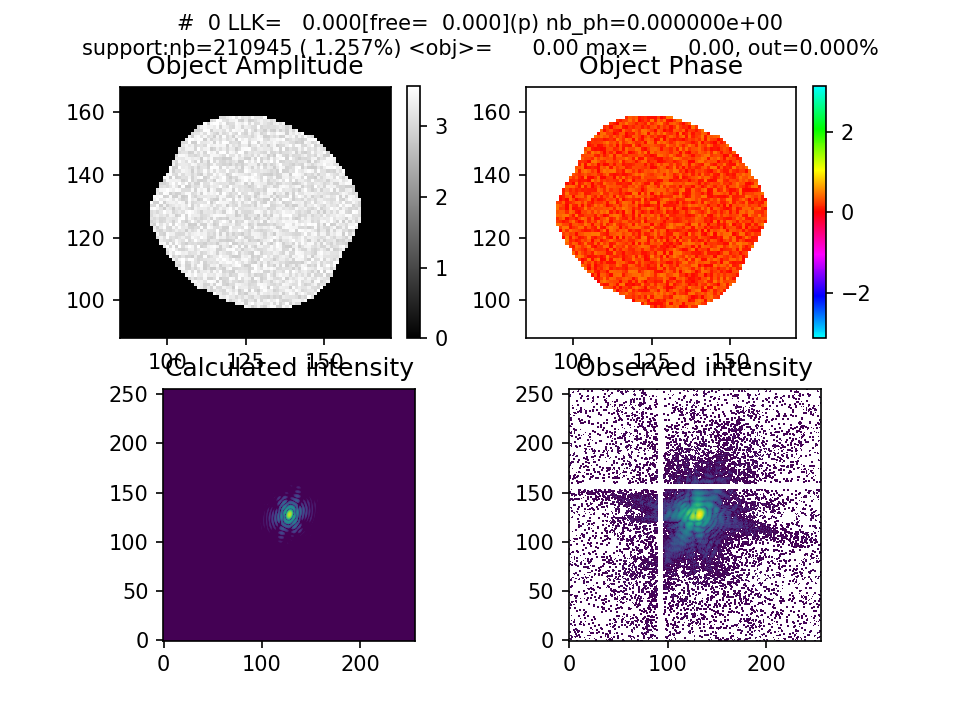

In [6]:
cdi = AutoCorrelationSupport(threshold=0.1) * cdi

cdi = ShowCDI() * ScaleObj() * InitObjRandom(src="support",amin=0.8,amax=1, phirange=0.5) * cdi

## Solve the object using RAAR & ER
The important parameters below which can affect the reconstruction are the support update ones. You can try:
* `SupportUpdate(threshold_relative=0.12, method='max', smooth_width=(2,0.5,600))`
* `SupportUpdate(threshold_relative=0.3, method='rms', smooth_width=(2,0.5,600))`

both should work in this case, but depending on datasets one may work better than the other

See the other support update options by typing `SupportUpdate?`

You can make more complex combinations of algorithms simply by multiplying the operators (ER, HIO, RAAR, SupportUpdate, CF,...) as you see fit.

Note that the recipe below should work on a majority of trials, but will sometimes fail. You can restart from a random object. 

<IPython.core.display.Javascript object>


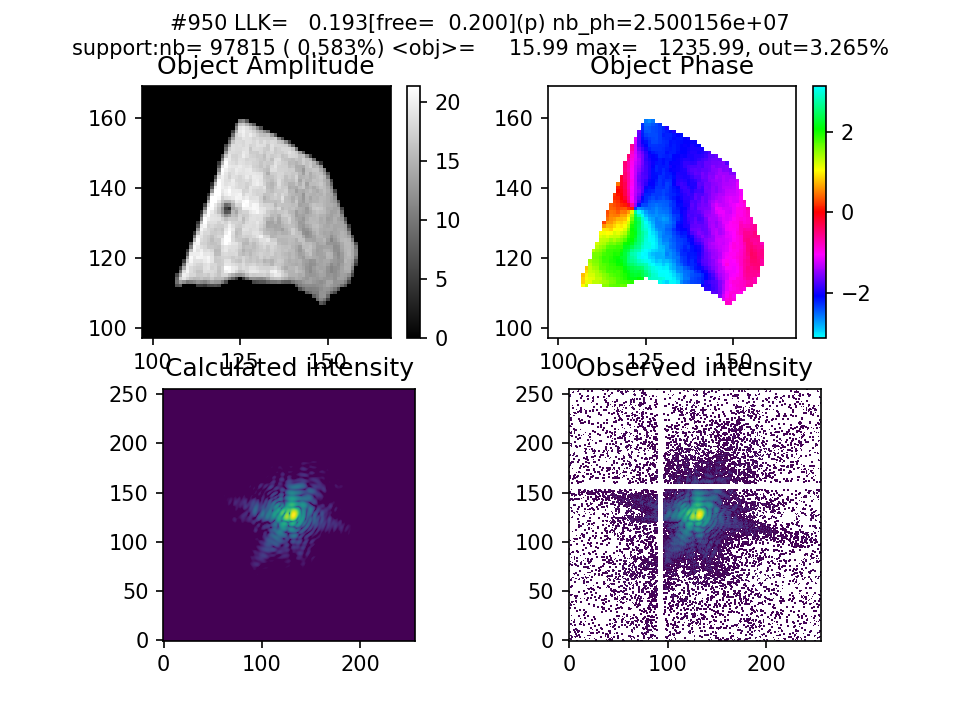

RAAR #  0 LLK=   7.227[free=  1.501](p), nb photons=2.179479e+06, support:nb=210945 ( 1.257%) <obj>=      3.21 max=   1179.13, out=58.622% dt/cycle=5.7350s 
RAAR # 50 LLK=   0.947[free=  0.356](p), nb photons=2.932234e+07, support:nb=194218 ( 1.158%) <obj>=     12.29 max=   1314.53, out=8.186% dt/cycle=0.0168s 
RAAR #100 LLK=   1.010[free=  0.360](p), nb photons=2.977872e+07, support:nb=183784 ( 1.095%) <obj>=     12.73 max=   1282.94, out=8.846% dt/cycle=0.0186s 
RAAR #150 LLK=   1.003[free=  0.418](p), nb photons=2.962149e+07, support:nb=160305 ( 0.955%) <obj>=     13.59 max=   1269.48, out=8.823% dt/cycle=0.0177s 
RAAR #200 LLK=   0.822[free=  0.423](p), nb photons=2.887883e+07, support:nb=127109 ( 0.758%) <obj>=     15.07 max=   1236.75, out=7.826% dt/cycle=0.0187s 
RAAR #250 LLK=   0.698[free=  0.328](p), nb photons=2.860738e+07, support:nb=113786 ( 0.678%) <obj>=     15.86 max=   1244.48, out=5.599% dt/cycle=0.0177s 
RAAR #300 LLK=   0.714[free=  0.334](p), nb photons=2.878732e+0

In [7]:
sup = SupportUpdate(threshold_relative=0.3, method='rms', smooth_width=(2,0.5,600))
plt.figure()
cdi = (sup * RAAR(beta=0.9, calc_llk=50, show_cdi=50)**20)**40 * cdi
cdi = (sup * ER(calc_llk=50, show_cdi=50)**20)**10 * cdi


## Save result in a CXI file
Type `cdi.save_obj_cxi?` to get the full documentation about the function

In [8]:
# cdi.save_obj_cxi("result.cxi")